In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import matplotlib as mpl
import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

from graph_generators import grid_2d
from simulations import sample_graph_from_infection, simulate_IC, make_input
from plot_utils import add_colorbar, get_display_kwargs

In [2]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

In [3]:
infp = 0.7
g = grid_2d(10, infp)
pos = {n: np.array(n) for n in g.nodes()}    
node2id = {n: i for i, n in enumerate(g.nodes_iter())}

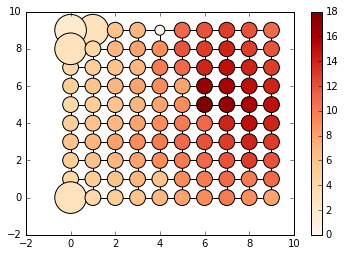

In [4]:
source, obs_nodes, infection_times, tree = make_input(g, infp, 0.05, sampling_method='late_nodes')
kwargs =get_display_kwargs(g, infection_times, obs_nodes=obs_nodes)
nx.draw_networkx(g, pos=pos, with_labels=False, **kwargs)
add_colorbar(kwargs['node_color'])

In [5]:
def generate_sufficient_stats(g):
    """
    given one graph, simulate an IC process from all nodes
    the same sampled graph is shared across all runs
    
    Returns:
    for each node as source, return the infection times and tree
    list of (source, times, tree)
    """
    g1 = sample_graph_from_infection(g)
    return [(s, ) + simulate_IC(g1, s=s, is_g_sampled=True, debug=False)
            for s in g.nodes()]

In [6]:
stat = generate_sufficient_stats(g)

In [7]:
N = 100
# list of list of (source, times, tree)
stats = Parallel(n_jobs=-1)(delayed(generate_sufficient_stats)(g) for i in range(N))

In [8]:
times_by_source = defaultdict(list)
for stat in stats:
    for s, times, _ in stat:
        times_array = np.array([times[n] for n in g.nodes()])
        times_by_source[s].append(times_array)
times_by_source = {s: np.array(times2d)
                   for s, times2d in times_by_source.items()}

In [9]:
def accuracy_for_nodes(query, outcome, times_by_source, node2id):
    """
    for each node as source, calculate the fraction of cascades that matches the "outcome" on node "query"
    """
    id_ = node2id[query]
    acc = {}
    for s, m in times_by_source.items():
        acc[s] = np.count_nonzero(m[:, id_] == outcome) / m.shape[0]
    return acc

In [10]:
acc = accuracy_for_nodes((0, 0), 12, times_by_source, node2id)

In [11]:
def print_nodes_by_mu(g, mu, source, top_k=5):
    sorted_nodes = list(sorted(g.nodes(), key=lambda n: mu[n], reverse=True))
    for n in sorted_nodes[:top_k]:
        print('{}: {:.5f}'.format(n, mu[n]))
    print('source ranks {} th'.format(sorted_nodes.index(source)+1))

In [12]:
def normalize_mu(mu):
    total = sum(mu.values())
    return {n: v / total for n, v in mu.items()}

In [93]:
epsilon = 0.8

def mwu(g, source, obs_nodes, infection_times, epsilon,
        debug=False, plot=False,
        max_plots=9):
    mu_of_source = []
    ### debugging START    
    if plot:
        ncols = 2
        nrows = math.ceil((max_plots) / ncols)
        width = 12
        height = int(width * nrows / ncols)
        fig, ax = plt.subplots(nrows, ncols,
                               sharex=True, sharey=True,
                               figsize=(width, height))
        kwargs = get_display_kwargs(g, infection_times, obs_nodes=obs_nodes)
        nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
        ax[0, 0].set_title('ground truth')
    ### debugging END
        
    node2id = {n: i for i, n in enumerate(g.nodes_iter())}
    mu = {n: 1 for n in g.nodes()}
    mu = normalize_mu(mu)
    mu_of_source.append(mu[source])

    query_count = 0
    queried_nodes = set()

    # using the observations
    for q in sorted(obs_nodes, key=lambda n: infection_times[n]):
        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)
        mu = normalize_mu(mu)
        queried_nodes.add(q)

    ### debugging START
    if debug:
        print_nodes_by_mu(g, mu, source)
        
    if plot and max_plots >= 1:
        i, j = 0, 1
        
        kwargs = get_display_kwargs(g, mu)
        likelihood_colors = [mu.get(n, 0) for n in g.nodes()]
        kwargs['node_color'] = likelihood_colors
        nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
        ax[i, j].set_title('using observation')
    ### debugging END
        
    max_iter = float('inf')
    iter_i = 0

    all_nodes = set(g.nodes())
    while iter_i < max_iter:
        iter_i += 1
        
        if len(all_nodes - queried_nodes) == 0:
            if debug:
                print('no more nodes to query')
            break
            
        q = max(all_nodes - queried_nodes, key=lambda n: mu[n])
        queried_nodes.add(q)        
        query_count += 1

        if debug:
            print('query {}'.format(q))

        # test if it's source by querying neighbors
        if iter_i > 15:
            is_source = np.all(list(map(lambda u: infection_times[q] < infection_times[u],
                                        g.neighbors(q))))
            query_count += len(list(filter(lambda u: u not in queried_nodes, g.neighbors(q))))
            if is_source:
                if debug:
                    print('**Found source')
                    print('used {} queries'.format(query_count))
                assert source == q
                break

        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)

        mu = normalize_mu(mu)    

        ### debugging START
        if plot and iter_i+2 <= max_plots:
            i, j = int((iter_i+1) / ncols), (iter_i+1) % ncols

            kwargs = get_display_kwargs(g, mu, obs_nodes={q})
            likelihood_colors = [mu.get(n, 0) for n in g.nodes()]
            kwargs['node_color'] = likelihood_colors
            nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
            ax[i, j].set_title('iter_i={}'.format(iter_i))
        ### debugging END
        
        mu_of_source.append(mu[source])
        if debug:        
            print('iteration: {}'.format(iter_i))
            print_nodes_by_mu(g, mu, source)

    return query_count, mu_of_source

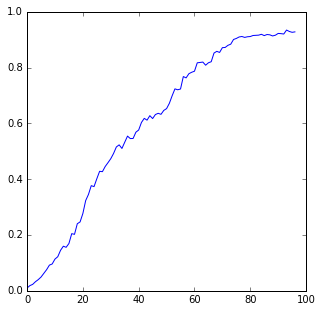

In [104]:
source, obs_nodes, infection_times, tree = make_input(g, infp=0.7, fraction=0.05, sampling_method='late_nodes')
query_count, mu_of_source = mwu(g, source, obs_nodes, infection_times, epsilon=0.3,
                            debug=False, 
                            plot=True,
                            max_plots=6)
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(mu_of_source)

In [14]:
def experiment_multiple_rounds(rounds, g, infp, fraction, epsilon, sampling_method):
    cnts = []
    for i in range(rounds):
        source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
        cnt = mwu(g, source, obs_nodes, infection_times, epsilon)
        cnts.append(cnt)
    return cnts

In [20]:
rounds = 500
infp = 0.7
fraction=0.05
epsilon = 0.5
cnts = experiment_multiple_rounds(rounds, g, infp, fraction, epsilon, 'late_nodes')

In [21]:
s1 = pd.Series(cnts)
s1.describe()

count    500.000000
mean      18.010000
std       11.549228
min        3.000000
25%        9.000000
50%       15.000000
75%       27.000000
max       49.000000
dtype: float64

In [22]:
epsilons = np.linspace(0.1, 0.9, 9)
rows = []

list_cnts = Parallel(n_jobs=-1)(delayed(experiment_multiple_rounds)(rounds, g, infp, fraction, epsilon, 'late_nodes')
                                for epsilon in epsilons)
# pd.DataFrame(rows, columns=['p', 'query count mean', 'query count median'])    

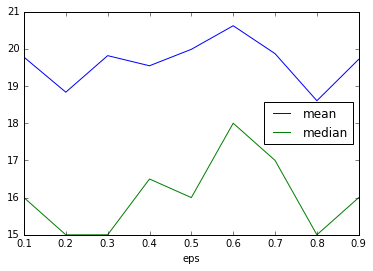

In [32]:
means = list(map(np.mean, list_cnts))
medians = list(map(np.median, list_cnts))
df = pd.DataFrame.from_dict({'eps': epsilons, 'mean': means, 'median': medians})

In [29]:
from baselines import baseline_dog_tracker

cnts = []
for i in range(rounds):
    source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method='late_nodes')
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    cnts.append(c)

**Found** source: (6, 9)
**Found** source: (2, 5)
**Found** source: (1, 1)
**Found** source: (1, 5)
**Found** source: (8, 9)
**Found** source: (2, 4)
**Found** source: (5, 6)
**Found** source: (6, 2)
**Found** source: (2, 9)
**Found** source: (9, 4)
**Found** source: (1, 5)
**Found** source: (5, 3)
**Found** source: (0, 8)
**Found** source: (7, 6)
**Found** source: (1, 2)
**Found** source: (5, 9)
**Found** source: (2, 0)
**Found** source: (1, 0)
**Found** source: (4, 7)
**Found** source: (2, 1)
**Found** source: (7, 8)
**Found** source: (8, 2)
**Found** source: (5, 2)
**Found** source: (2, 1)
**Found** source: (4, 6)
**Found** source: (6, 7)
**Found** source: (4, 0)
**Found** source: (4, 0)
**Found** source: (1, 8)
**Found** source: (8, 4)
**Found** source: (2, 3)
**Found** source: (7, 6)
**Found** source: (5, 6)
**Found** source: (1, 3)
**Found** source: (6, 8)
**Found** source: (2, 4)
**Found** source: (3, 1)
**Found** source: (8, 8)
**Found** source: (4, 5)
**Found** source: (5, 0)


In [30]:
print('mean', np.mean(cnts))
print('median', np.median(cnts))

mean 24.036
median 23.0


(0, 30)

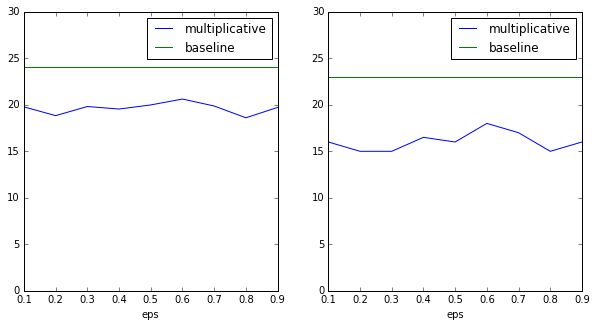

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axes
df.plot(x='eps', y=['mean'], ax=ax0)
ax0.plot([np.mean(cnts)] * len(epsilons))
ax0.legend(['multiplicative', 'baseline'])
ax0.set_ylim(0, 30)

df.plot(x='eps', y=['median'], ax=axes[1])
ax1.plot([np.median(cnts)] * len(epsilons))
ax1.legend(['multiplicative', 'baseline'])
ax1.set_ylim(0, 30)